# ============================================================
# IMPORTS & HELPERS (Code Cell)
# ============================================================

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Utility function for clean plotting
def show(title, img, cmap='gray'):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ============================================================
# Task 1 — Binary Image + Structuring Element
# ============================================================

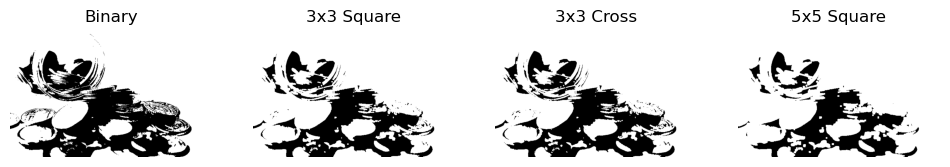

In [31]:
img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)


se_square_3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
se_cross_3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
se_square_5 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))


dil_1 = cv2.dilate(binary, se_square_3)
dil_2 = cv2.dilate(binary, se_cross_3)
dil_3 = cv2.dilate(binary, se_square_5)


plt.figure(figsize=(12,3))
for i, (title, im) in enumerate([
('Binary', binary),
('3x3 Square', dil_1),
('3x3 Cross', dil_2),
('5x5 Square', dil_3)
]):
    plt.subplot(1,4,i+1)
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()

# Observation:
# Square SEs grow objects uniformly, while cross SE preserves thin structures.

# ============================================================
# Task 2 — Noise Removal Without Touching the Object
# ============================================================

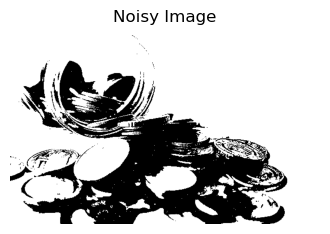

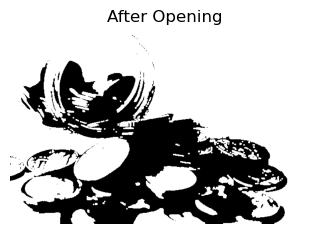

In [32]:
noise = binary.copy()

coords = [
    np.random.randint(0, noise.shape[0], 300),
    np.random.randint(0, noise.shape[1], 300),
]

noise[coords[0], coords[1]] = 255


opened = cv2.morphologyEx(noise, cv2.MORPH_OPEN, se_square_3)


show("Noisy Image", noise)
show("After Opening", opened)

# Observation:
# Opening removes isolated noise without affecting main objects.

# ============================================================
# Task 3 — Fill Gaps in Broken Objects
# ============================================================

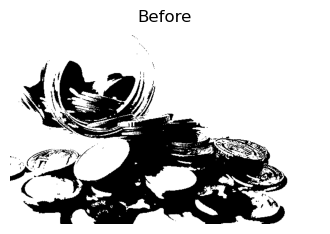

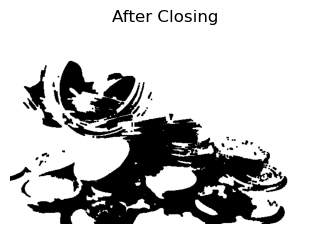

In [33]:
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, se_square_3)


show("Before", binary)
show("After Closing", closed)

# Observation:
# Large SEs overfill and distort object boundaries.

# ============================================================
# Task 4 — Sobel vs Canny
# ============================================================

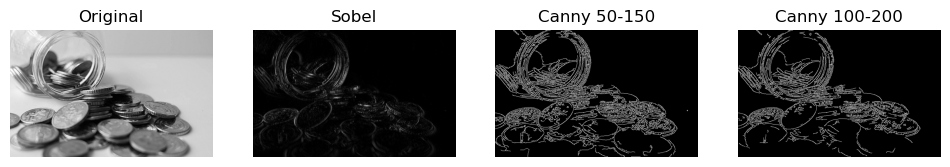

In [34]:
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobelx = np.abs(sobelx)


canny1 = cv2.Canny(img, 50, 150)
canny2 = cv2.Canny(img, 100, 200)


plt.figure(figsize=(12,3))
for i, (title, im) in enumerate([
('Original', img),
('Sobel', sobelx),
('Canny 50-150', canny1),
('Canny 100-200', canny2)
]):
    plt.subplot(1,4,i+1)
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()

# Observation:
# Weak edges disappear first as Canny thresholds increase.

# ============================================================
# Task 5 — Line Detection (Hough)
# ============================================================

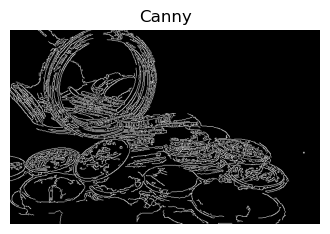

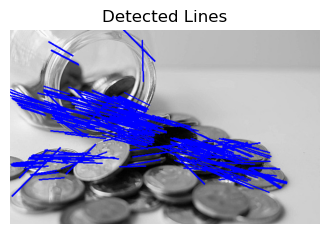

In [35]:
lines = cv2.HoughLinesP(canny1, 1, np.pi/180, threshold=100,
minLineLength=50, maxLineGap=10)


line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(line_img, (x1,y1), (x2,y2), (0,0,255), 2)


show('Canny', canny1)
show('Detected Lines', line_img, cmap=None)

# Observation:
# Low thresholds produce many false-positive lines.

# ============================================================
# Task 6 — Fourier Transform
# ============================================================

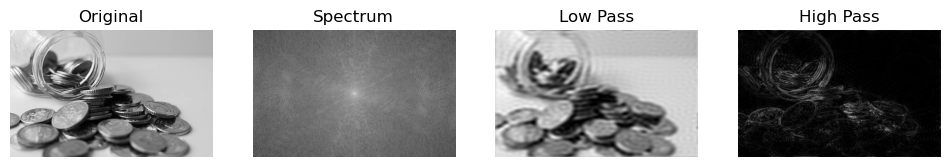

In [36]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude = np.log(1 + np.abs(fshift))


rows, cols = img.shape
crow, ccol = rows//2, cols//2


mask_low = np.zeros((rows, cols), np.uint8)
cv2.circle(mask_low, (ccol, crow), 30, 1, -1)


low_pass = fshift * mask_low
high_pass = fshift * (1 - mask_low)


img_low = np.abs(np.fft.ifft2(np.fft.ifftshift(low_pass)))
img_high = np.abs(np.fft.ifft2(np.fft.ifftshift(high_pass)))


plt.figure(figsize=(12,3))
for i, (title, im) in enumerate([
('Original', img),
('Spectrum', magnitude),
('Low Pass', img_low),
('High Pass', img_high)
]):
    plt.subplot(1,4,i+1)
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()

# Observation:
# High-pass filtering emphasizes edges strongly.

# ============================================================
# Task 7 — Contours as Object Boundaries
# ============================================================

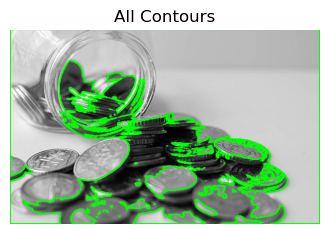

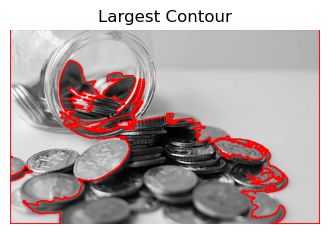

In [37]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


cont_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(cont_img, contours, -1, (0, 255, 0), 2)


largest = max(contours, key=cv2.contourArea)
large_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(large_img, [largest], -1, (255, 0, 0), 2)


show("All Contours", cont_img, cmap=None)
show("Largest Contour", large_img, cmap=None)

# Observation:
# Poor thresholding causes fragmented or missing contours.

# ============================================================
# Final Challenge — Combined Pipeline
# ============================================================

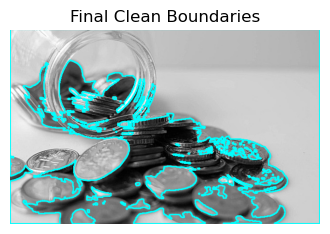

In [38]:
clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, se_square_3)
edges = cv2.Canny(clean, 50, 150)
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


final = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(final, contours, -1, (0, 255, 255), 2)


show("Final Clean Boundaries", final, cmap=None)